# Modelo para predicción de niveles de obesidad


In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings
from sklearn.metrics import confusion_matrix
import pickle
warnings.filterwarnings("ignore")

## Carga de datos

In [98]:
df = pd.read_csv('obesity_dataset.csv')
df.head(5)

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Exploratory Data Analysis

In [99]:
df.shape

(2111, 17)

In [100]:
df.columns

Index(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC',
       'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS',
       'Obesity'],
      dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

In [102]:
df.drop(columns=['Height', 'Weight'], inplace=True) # Se eliminan porque son variables que construyen el target

In [103]:
categorical_columns = ["Gender", "family_history", "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS", "Obesity"]
continuos_columns = ["Age","FCVC","NCP","CH2O","FAF", "TUE"]
target_col = ["Obesity"]
print("Las columnas categóricas son: ", categorical_columns)
print("Las columnas continuas son: ", continuos_columns)
print("La variable target es:  ", target_col)

Las columnas categóricas son:  ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'Obesity']
Las columnas continuas son:  ['Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
La variable target es:   ['Obesity']


In [104]:
df.describe()

,Age,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [105]:
df.isnull().sum() # No hay datos faltantes
df.dropna(inplace=True)
df.duplicated().sum()
df.drop_duplicates(inplace=True)

### Variables continuas

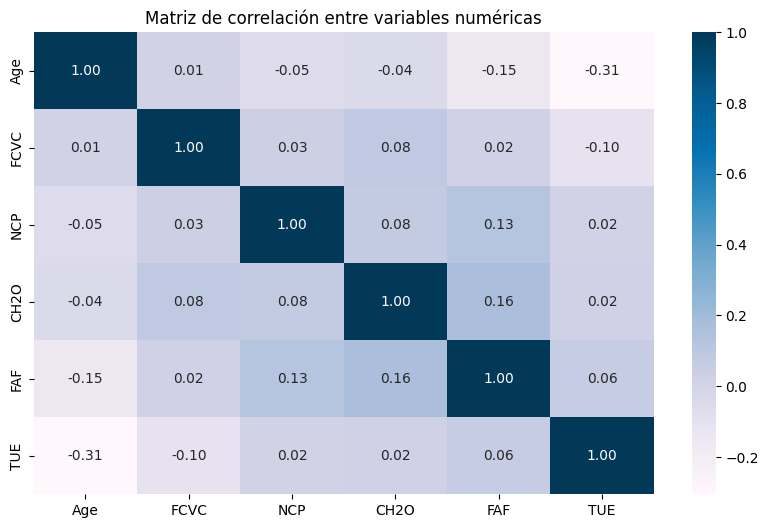

In [106]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=['float64']).corr(), annot=True, cmap="PuBu", fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

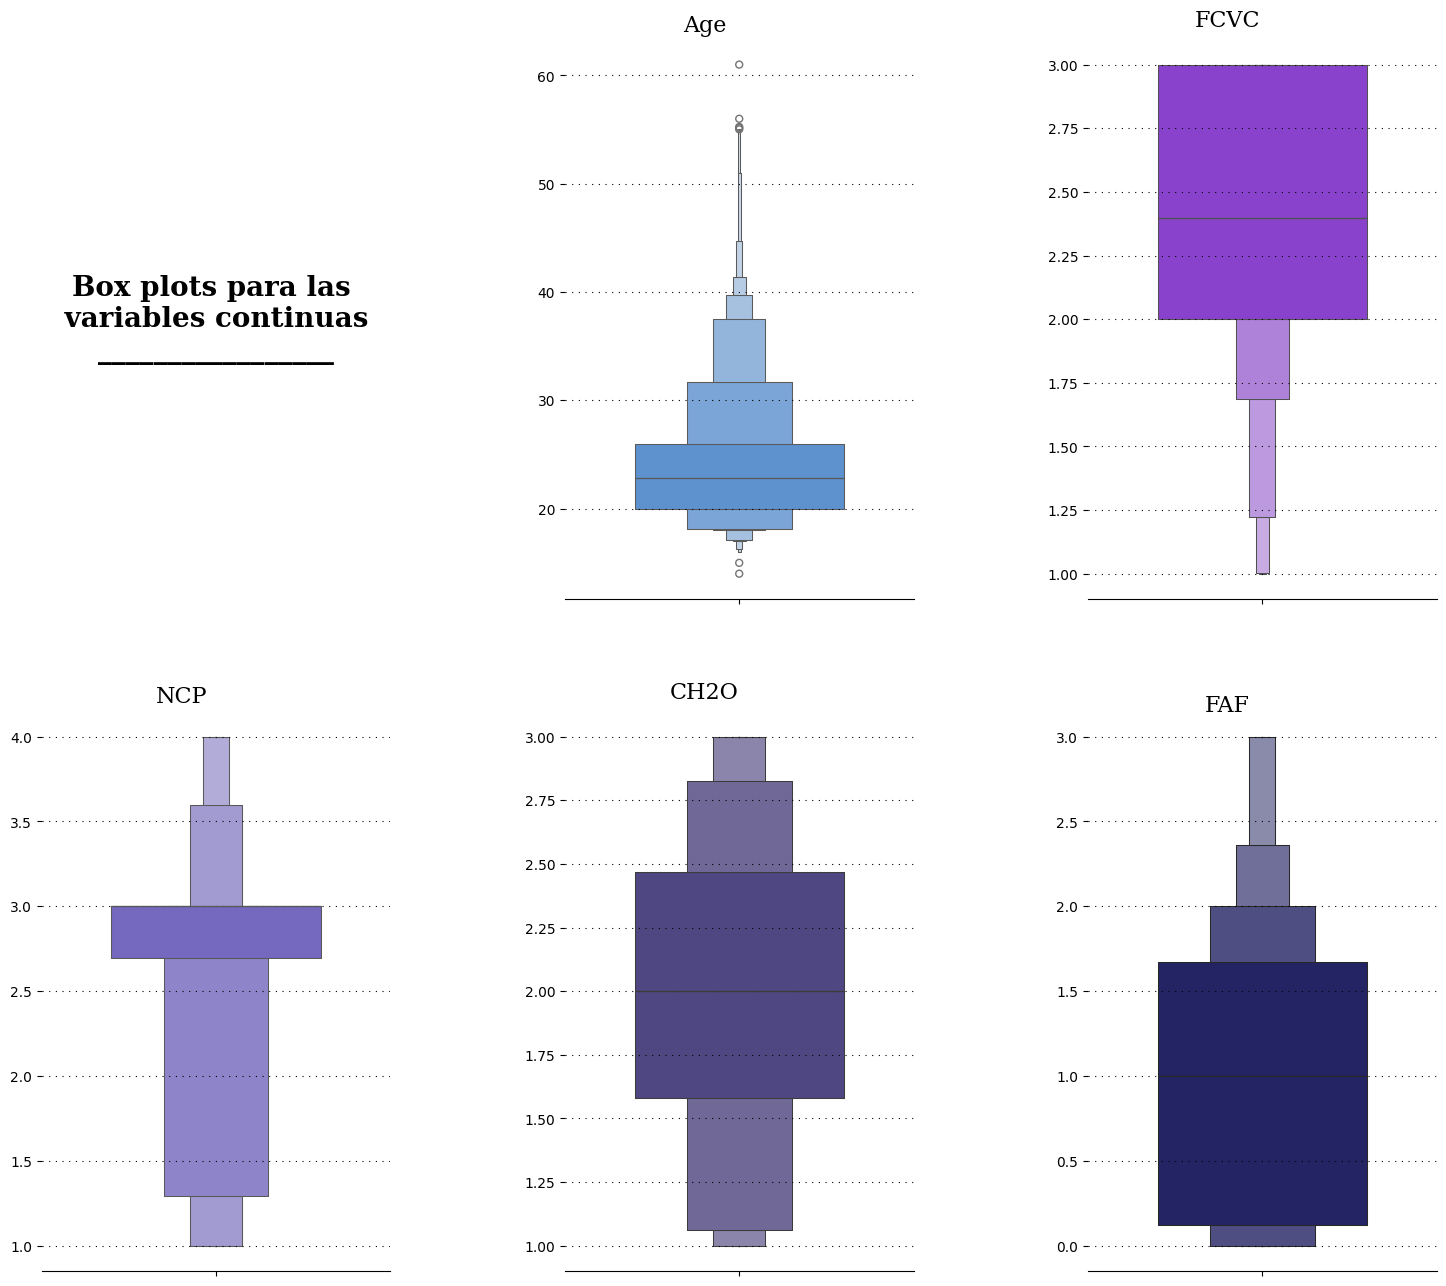

In [107]:
fig = plt.figure(figsize=(18, 16))
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.5, hspace=0.2)

axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

background_color = "#ffffff"
color_palette = ["#4A90E2", "#8A2BE2", "#6A5ACD", "#483D8B", "#191970", "#2E2B5F"]

fig.patch.set_facecolor(background_color)
for ax in axes:
    ax.set_facecolor(background_color)

# Título general
axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(
    0.5,
    0.5,
    'Box plots para las \n variables continuas \n_________________',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=20,
    fontweight='bold',
    fontfamily='serif',
    color="#000000",
)

# Columnas continuas
continuous_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF", "TUE"]

for ax, col, color in zip(axes[1:], continuous_columns, color_palette):
    ax.text(
        -0.1, df[col].max() * 1.05, col,
        fontsize=16, fontweight='light', fontfamily='serif', color="#000000",
        horizontalalignment='center'
    )
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
    sns.boxenplot(ax=ax, y=df[col], palette=[color], width=0.6)
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.show()


### Variables categóricas

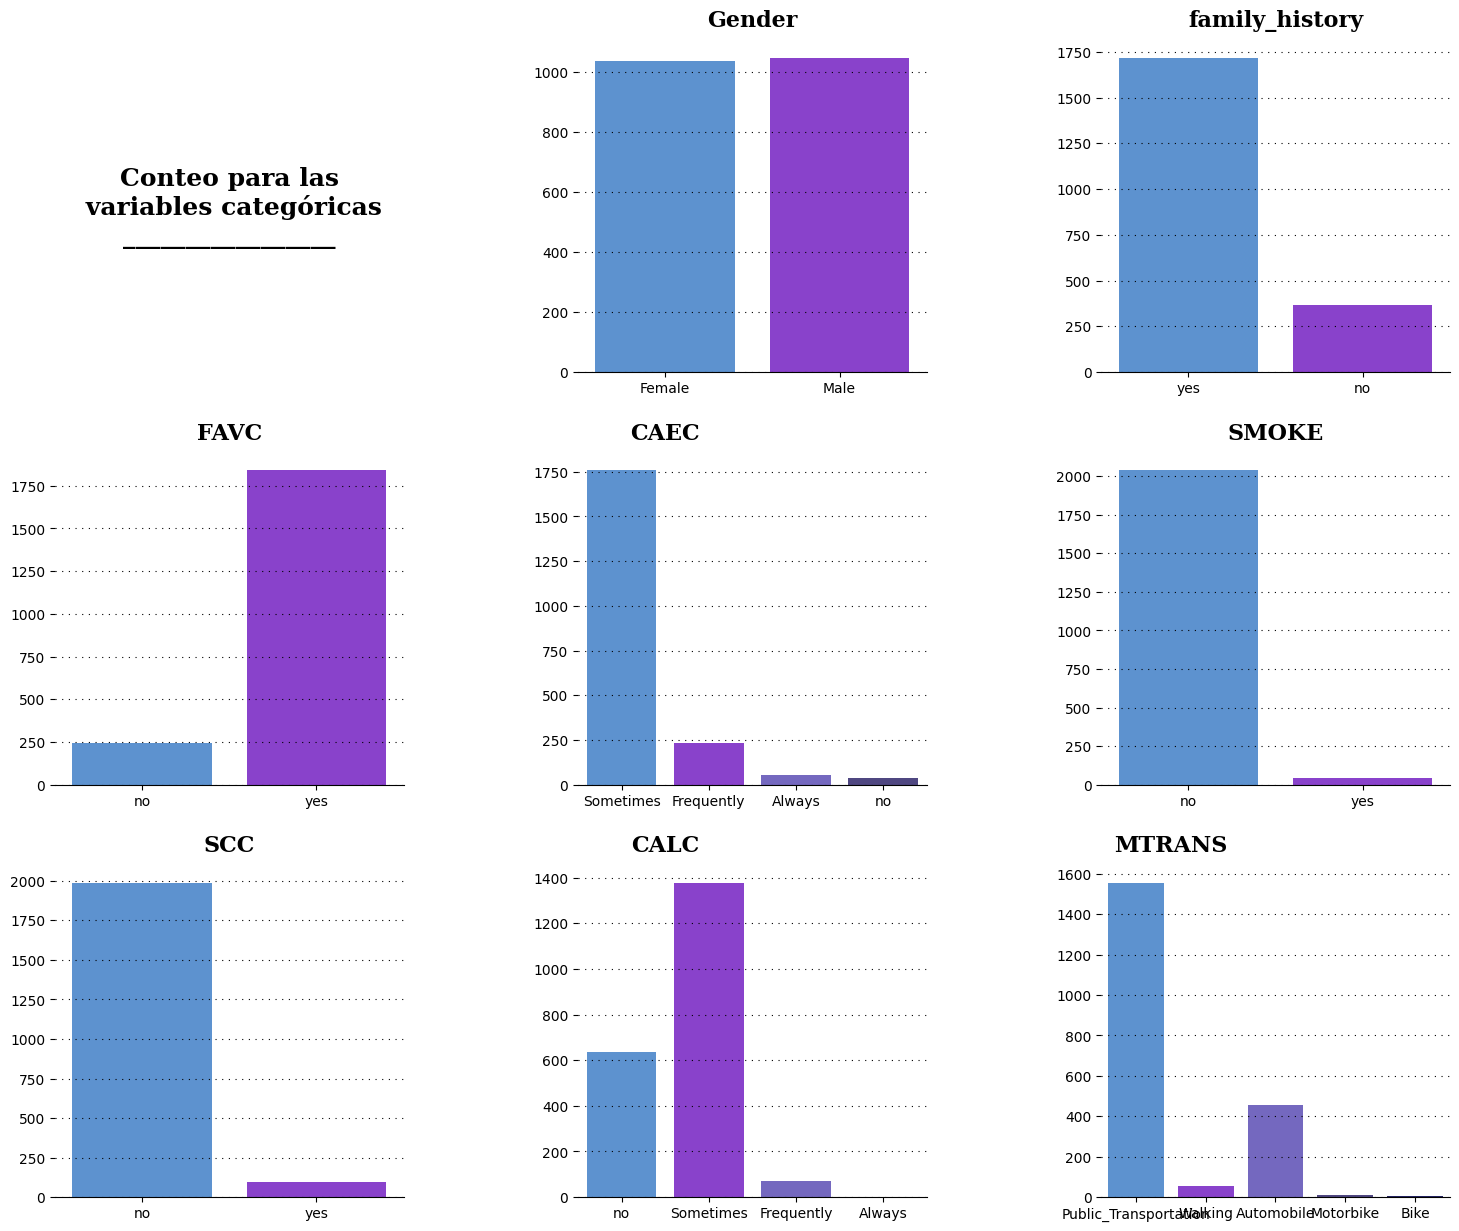

In [108]:
fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.5, hspace=0.25)

axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

fig.patch.set_facecolor(background_color)
for ax in axes:
    ax.set_facecolor(background_color)

axes[0].spines["bottom"].set_visible(False)
axes[0].spines["left"].set_visible(False)
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)
axes[0].tick_params(left=False, bottom=False)
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].text(
    0.5,
    0.5,
    'Conteo para las\n variables categóricas\n_________________',
    horizontalalignment='center',
    verticalalignment='center',
    fontsize=18,
    fontweight='bold',
    fontfamily='serif',
    color="#000000",
)

for ax, col in zip(axes[1:], categorical_columns):
    ax.text(
        0.5, df[col].value_counts().max() * 1.1, col,
        fontsize=16, fontweight='bold', fontfamily='serif', color="#000000",
        horizontalalignment='center'
    )
    ax.grid(color='#000000', linestyle=':', axis='y', zorder=0, dashes=(1, 5))
    sns.countplot(ax=ax, data=df, x=col, palette=color_palette)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

plt.show()

### Variable Objetivo (Obesity)

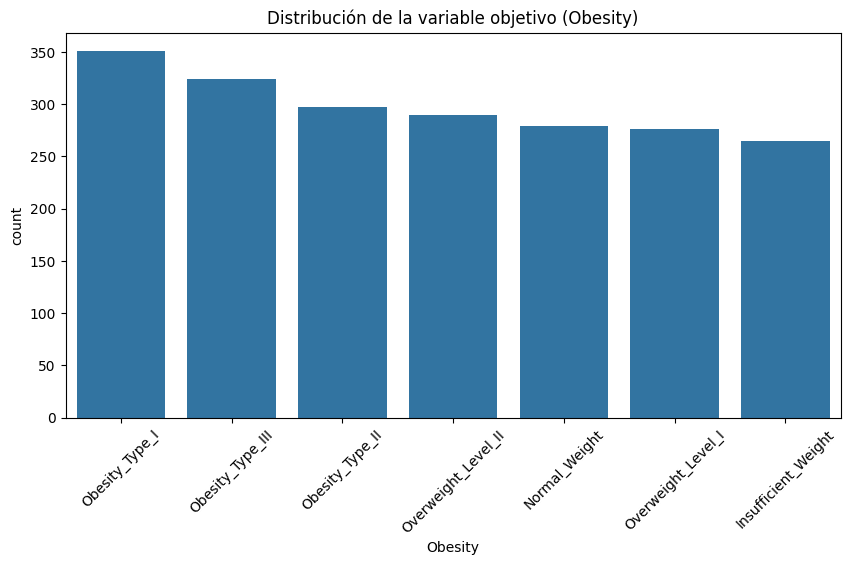

In [109]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Obesity", order=df["Obesity"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribución de la variable objetivo (Obesity)")
plt.show()

## Transformación de datos

In [110]:
df_encoders = df.copy()

one_hot_cols = ["Gender", "MTRANS"]
df_encoders = pd.get_dummies(df_encoders, columns=one_hot_cols, drop_first=True)

binary_cols = ["family_history", "FAVC", "SMOKE", "SCC"]
for col in binary_cols:
    le = LabelEncoder()
    df_encoders[col] = le.fit_transform(df_encoders[col])

ordinal_mappings = {
    "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "Obesity": {
        "Insufficient_Weight": 0,
        "Normal_Weight": 1,
        "Overweight_Level_I": 2,
        "Overweight_Level_II": 3,
        "Obesity_Type_I": 4,
        "Obesity_Type_II": 5,
        "Obesity_Type_III": 6
    }
}
for col, mapping in ordinal_mappings.items():
    df_encoders[col] = df_encoders[col].map(mapping)

df_encoders.head()

,Age,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,Obesity,Gender_Male,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1,False,False,False,True,False
1,21.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1,False,False,False,True,False
2,23.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1,True,False,False,True,False
3,27.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,2,True,False,False,False,True
4,22.0,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,3,True,False,False,True,False


## Entrenamiento del modelo

In [ ]:
X = df_encoders.drop(columns=["Obesity"])
y = df_encoders["Obesity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
models = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
            "subsample": [0.8, 1.0],
        },
    },
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
        },
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.01, 0.1, 0.2],
        },
    }
}


best_models = {}
for model_name, config in models.items():
    grid_search = GridSearchCV(config["model"], config["params"], cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

results = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    results[model_name] = classification_report(y_test, y_pred, output_dict=True)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:52:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'XGBoost': {'0': {'precision': 0.8888888888888888,
   'recall': 0.8888888888888888,
   'f1-score': 0.8888888888888888,
   'support': 54.0},
  '1': {'precision': 0.6290322580645161,
   'recall': 0.6724137931034483,
   'f1-score': 0.65,
   'support': 58.0},
  '2': {'precision': 0.7543859649122807,
   'recall': 0.7413793103448276,
   'f1-score': 0.7478260869565218,
   'support': 58.0},
  '3': {'precision': 0.8,
   'recall': 0.7586206896551724,
   'f1-score': 0.7787610619469026,
   'support': 58.0},
  '4': {'precision': 0.8055555555555556,
   'recall': 0.8285714285714286,
   'f1-score': 0.8169014084507042,
   'support': 70.0},
  '5': {'precision': 0.9166666666666666,
   'recall': 0.9166666666666666,
   'f1-score': 0.9166666666666666,
   'support': 60.0},
  '6': {'precision': 1.0,
   'recall': 0.9692307692307692,
   'f1-score': 0.984375,
   'support': 65.0},
  'accuracy': 0.8274231678486997,
  'macro avg': {'precision': 0.8277899048697012,
   'recall': 0.8251102209230289,
   'f1-score': 0.

## Selección del modelo final
### Evaluación

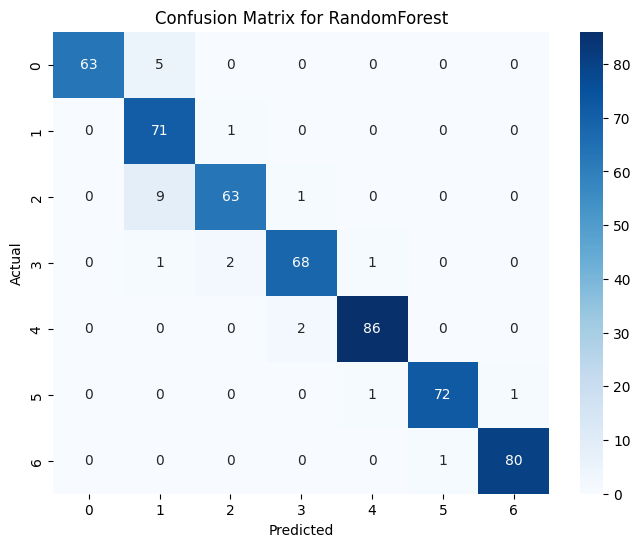

Best Model: RandomForest
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        68
           1       0.83      0.99      0.90        72
           2       0.95      0.86      0.91        73
           3       0.96      0.94      0.95        72
           4       0.98      0.98      0.98        88
           5       0.99      0.97      0.98        74
           6       0.99      0.99      0.99        81

    accuracy                           0.95       528
   macro avg       0.96      0.95      0.95       528
weighted avg       0.96      0.95      0.95       528



In [54]:
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = best_models[best_model_name]

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
final_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

print(f"Best Model: {best_model_name}")
print(final_report)

In [95]:
model_filename = "modelo_final.pkl"
with open(model_filename, "wb") as model_file:
    pickle.dump(best_model, model_file)

print(f"Modelo guardado como {model_filename}")

Modelo guardado como modelo_final.pkl
